In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [4]:
device=torch.device('cuda:1') #先調1再調0

In [5]:
x=torch.randn(1000, 6724)
x=x.to(device)

In [6]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/data_reserved/Re_100/input_u_fake.dat')
data_out=np.loadtxt('./data/data_reserved/Re_100/output_p.dat')
x=torch.Tensor(data_in)
y=torch.Tensor(data_out)
x=x.to(device)
y=y.to(device)
x=x[:8000]
y=y[:8000]
print(x.size())
print(y.size())

torch.Size([8000, 6724])
torch.Size([8000, 6724])


In [8]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, B, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, H)
        self.linear_2=torch.nn.Linear(H, B)
        self.linear_3=torch.nn.Linear(B, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        h=self.linear_1(x)
        h_relu=torch.nn.functional.relu(h) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(h_relu) 
        b_relu=torch.nn.functional.relu(b)
        y_pred=self.linear_3(b_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6400, H=1000, B=1000, D_out=6400)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

In [7]:
x= torch.nn.Sequential(torch.nn.Unflatten(1, (1,82,82)))(x)
# Convolutional neural network (two convolutional layers)
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, channel_1, channel_2, kernel_dim):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, channel_1, kernel_dim)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_dim)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(78*78*3, 1000)  # 78*78 from image dimension
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 6724)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet(channel_1=3, channel_2=3, kernel_dim=3).to(device)

In [8]:
loader=DataLoader(TensorDataset(x, y), batch_size=200)
tol=1e-8

In [9]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

In [10]:
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [ ]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)
        loss=torch.nn.functional.mse_loss(y_pred, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss


C:\Users\ENCHOU\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epochs:  1 ; Loss:  8.508725295541808e-05
Epochs:  2 ; Loss:  2.906091140175704e-06
Epochs:  3 ; Loss:  5.852918548043817e-05
Epochs:  4 ; Loss:  6.180214768392034e-06
Epochs:  5 ; Loss:  0.0001799257006496191
Epochs:  6 ; Loss:  4.879911443822493e-07
Epochs:  7 ; Loss:  0.00046651175944134593
Epochs:  8 ; Loss:  3.703044910707831e-07
Epochs:  9 ; Loss:  0.00017881119856610894
Epochs:  10 ; Loss:  1.7290607502218336e-05
Epochs:  11 ; Loss:  2.81322115824878e-07
Epochs:  12 ; Loss:  0.0002774156746454537
Epochs:  13 ; Loss:  4.1002266470968607e-07
Epochs:  14 ; Loss:  3.42422083576821e-07
Epochs:  15 ; Loss:  2.998040713464434e-07
Epochs:  16 ; Loss:  6.955381104489788e-05
Epochs:  17 ; Loss:  2.2962036894114135e-07
Epochs:  18 ; Loss:  2.2320921289065154e-07
Epochs:  19 ; Loss:  2.1123636884112784e-07
Epochs:  20 ; Loss:  1.9296457764994557e-07
Epochs:  21 ; Loss:  1.733291128402925e-07
Epochs:  22 ; Loss:  1.7332381219148374e-07
Epochs:  23 ; Loss:  2.6031833044726227e-07
Epochs:  24 

Epochs:  187 ; Loss:  1.6174606116692303e-06
Epochs:  188 ; Loss:  1.5070633025970892e-06
Epochs:  189 ; Loss:  1.6862944676176994e-06
Epochs:  190 ; Loss:  1.445913198949711e-06
Epochs:  191 ; Loss:  1.621256615180755e-06
Epochs:  192 ; Loss:  1.5029743281047558e-06
Epochs:  193 ; Loss:  1.5852374417590909e-06
Epochs:  194 ; Loss:  1.4813471125307842e-06
Epochs:  195 ; Loss:  1.6532633253518725e-06
Epochs:  196 ; Loss:  1.525608809060941e-06
Epochs:  197 ; Loss:  1.5656851246603765e-06
Epochs:  198 ; Loss:  1.532586793473456e-06
Epochs:  199 ; Loss:  1.61866216785711e-06
Epochs:  200 ; Loss:  1.5083635389601113e-06
Epochs:  201 ; Loss:  1.60888714617613e-06
Epochs:  202 ; Loss:  1.5093930869625183e-06
Epochs:  203 ; Loss:  1.608886350368266e-06
Epochs:  204 ; Loss:  1.458711039958871e-06
Epochs:  205 ; Loss:  1.6470721675432287e-06
Epochs:  206 ; Loss:  1.49579079788964e-06
Epochs:  207 ; Loss:  1.627239385015855e-06
Epochs:  208 ; Loss:  1.4853994798613712e-06
Epochs:  209 ; Loss:  1

Epochs:  371 ; Loss:  1.604254521225812e-06
Epochs:  372 ; Loss:  1.471104155825742e-06
Epochs:  373 ; Loss:  1.6365825104003306e-06
Epochs:  374 ; Loss:  1.4732651152371545e-06
Epochs:  375 ; Loss:  1.6300185734507977e-06
Epochs:  376 ; Loss:  1.5052421531436266e-06
Epochs:  377 ; Loss:  1.6584702962063602e-06
Epochs:  378 ; Loss:  1.490925342295668e-06
Epochs:  379 ; Loss:  1.5906422277112142e-06
Epochs:  380 ; Loss:  1.483179175920668e-06
Epochs:  381 ; Loss:  1.6262571307379403e-06
Epochs:  382 ; Loss:  1.4843935787212104e-06
Epochs:  383 ; Loss:  1.6103525695143617e-06
Epochs:  384 ; Loss:  1.5255200196406804e-06
Epochs:  385 ; Loss:  1.5956599099808955e-06
Epochs:  386 ; Loss:  1.492783553658228e-06
Epochs:  387 ; Loss:  1.6522263877050136e-06
Epochs:  388 ; Loss:  1.447114186703402e-06
Epochs:  389 ; Loss:  1.6182234503503423e-06
Epochs:  390 ; Loss:  1.4516704140987713e-06
Epochs:  391 ; Loss:  1.6686532262610854e-06
Epochs:  392 ; Loss:  1.4900483620294835e-06
Epochs:  393 ; L

Text(0, 0.5, 'loss')

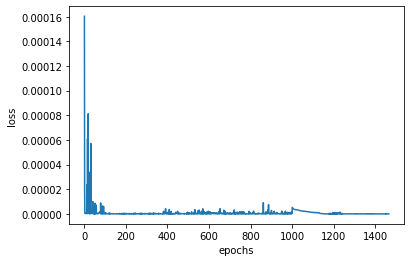

In [17]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()

In [ ]:
device=torch.device('cpu')
model=model.to(device)
PATH= "model_jit_E.pth"
traced_net=torch.jit.trace(model, (torch.randn(1,6400).to(torch.float64)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)